실제로 데이터의 제시 조건이 맞는지 검산

> 첫 번째 단어 A

> 문항 일련 번호 내 실험지 번호

> 시험지 번호 가운데 3자리 모두 000


사용자 분석 
---
사용자 문항 개수 도수분포표

사용자 정답률 도수분포표

문항 별 정답률 분석

시험지 별 정답률 분석



일반 EDA
---
문항을 많이 풀면 더 문제를 잘 맞추는 경향이 있다. - 연관성(0.168)

더 많이 노출된 태그가 정답률이 더 높다. - 연관성(0.376)

문항을 풀 수록 실력이 늘어나는가? - 문제를 많이 푼 학생과 정답률의 비율은 크지 않다.

문항을 푸는 데 걸린 시간과 정답률 사이 관계 - 너무 빨리 풀면 오답률이 높고 너무 늦게 풀어도 오답률이 높다.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

In [3]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   


In [4]:
DATA_PATH = '/opt/ml/input/data' + '/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [5]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


---

내 실험
---

~~시험지당 문제 갯수~~

~~한 시험지 당 문제 난이도 분포~~

~~한 시험지 당 문제 난이도 배열 순서(어려운게 빨리 나오면 멘붕 가능성 높음)~~

한 시험지 당 문제 풀이 시간 (시간 부족으로 마지막에 못 풀 가능성 존재) - (노이즈에 해당)

~~한 유저당 정답률 상승 추이~~

~~testId의 앞 숫자가 정답률에 영향을 줄까?~~

~~에밍하우스의 망각곡선을 고려해서 시험지 사이의 시간간격과 성적 변화가 유의미한지 확인하기~~

~~문제 풀이 시간이 정답률에 문제를 주나??[밤에 풀 때, 낮에 풀 때]~~

중복해서 푼 문제의 성적 상승률??


In [6]:
def percentile(x):
    return sum(x) / len(x)

In [7]:
def trim(x):
    return [i[-3:] for i in x]

In [8]:
def concat(x):
    res = []
    for i in x:
        res.extend(i)
    return sorted(set(res))

## 시험지당 문제 갯수 정상적인지

In [60]:
Quizs_in_test_per_user = df.groupby(['userID', 'testId']).agg({'assessmentItemID' : trim})
Quizs_in_test_per_user['assessmentItemID'] = \
    Quizs_in_test_per_user['assessmentItemID'].apply(set).apply(sorted)
Quizs_in_test_per_user.reset_index(inplace=True)
Quizs_in_test_per_user

,userID,testId,assessmentItemID
0,0,A020000172,"[001, 002, 003, 004, 005, 006]"
1,0,A020000174,"[001, 002, 003, 004, 005]"
2,0,A020000181,"[001, 002, 003, 004, 005, 006]"
3,0,A020000182,"[001, 002, 003, 004, 005]"
4,0,A020000183,"[001, 002, 003, 004, 005, 006, 007]"
...,...,...,...
365159,7440,A030000136,"[001, 002, 003, 004, 005]"
365160,7440,A030000197,"[001, 002, 003, 004, 005]"
365161,7440,A050000096,"[001, 002, 003, 004, 005]"
365162,7441,A030000071,"[001, 002, 003, 004, 005]"


In [61]:
Quizs_in_test = Quizs_in_test_per_user\
    .groupby('testId')\
    .agg({'assessmentItemID': concat})
Quizs_in_test

,assessmentItemID
testId,
A010000001,"[001, 002, 003, 004, 005]"
A010000002,"[001, 002, 003, 004, 005]"
A010000003,"[001, 002, 003, 004, 005]"
A010000004,"[001, 002, 003, 004, 005]"
A010000005,"[001, 002, 003, 004, 005]"
...,...
A090000070,"[001, 002, 003, 004, 005, 006, 007, 008]"
A090000071,"[001, 002, 003, 004, 005, 006, 007, 008]"
A090000072,"[001, 002, 003, 004, 005, 006]"


<AxesSubplot:>

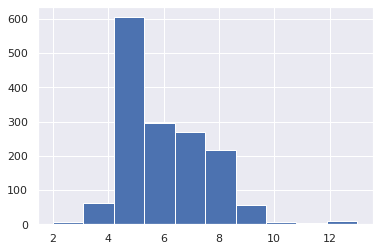

In [62]:
Quizs_in_test['assessmentItemID'].map(len).hist()

In [63]:
L = pd.merge(Quizs_in_test_per_user, Quizs_in_test, on='testId')
L['eq'] = L['assessmentItemID_x'] == L['assessmentItemID_y']
L

,userID,testId,assessmentItemID_x,assessmentItemID_y,eq
0,0,A020000172,"[001, 002, 003, 004, 005, 006]","[001, 002, 003, 004, 005, 006]",True
1,14,A020000172,"[001, 002, 003, 004, 005, 006]","[001, 002, 003, 004, 005, 006]",True
2,81,A020000172,"[001, 002, 003, 004, 005, 006]","[001, 002, 003, 004, 005, 006]",True
3,95,A020000172,"[001, 002, 003, 004, 005, 006]","[001, 002, 003, 004, 005, 006]",True
4,102,A020000172,"[001, 002, 003, 004, 005, 006]","[001, 002, 003, 004, 005, 006]",True
...,...,...,...,...,...
365159,4289,A010000189,"[001, 002, 003, 004, 005]","[001, 002, 003, 004, 005]",True
365160,4965,A010000189,"[001, 002, 003, 004, 005]","[001, 002, 003, 004, 005]",True
365161,5189,A010000189,"[001, 002, 003, 004, 005]","[001, 002, 003, 004, 005]",True
365162,5472,A010000189,"[001, 002, 003, 004, 005]","[001, 002, 003, 004, 005]",True


In [64]:
L[L['eq'] == False]

,userID,testId,assessmentItemID_x,assessmentItemID_y,eq


## 한 시험지당 난이도 분포

> 어려운 문제가 먼저 나오면 멘붕에 걸려서 시험지의 정답률이 낮아지나??

> 결론 : 어려운 문제가 앞에 배치되어서 못 푼다기보다 그저 어려운 문제가 많이 나와서 못 푸는 듯 하다.

In [80]:
difficulty = df.groupby('assessmentItemID').agg({
    'answerCode' : percentile
})
difficulty = difficulty['answerCode'].to_dict()
difficulty

{'A010001001': 0.9305993690851735,
 'A010001002': 0.9589905362776026,
 'A010001003': 0.9053627760252366,
 'A010001004': 0.9495268138801262,
 'A010001005': 0.886435331230284,
 'A010002001': 0.9838709677419355,
 'A010002002': 0.9096774193548387,
 'A010002003': 0.9741935483870968,
 'A010002004': 0.9741935483870968,
 'A010002005': 0.8161290322580645,
 'A010003001': 0.9597523219814241,
 'A010003002': 0.978328173374613,
 'A010003003': 0.8668730650154799,
 'A010003004': 0.6068111455108359,
 'A010003005': 0.8204334365325078,
 'A010004001': 0.9448051948051948,
 'A010004002': 0.9805194805194806,
 'A010004003': 0.9545454545454546,
 'A010004004': 0.9642857142857143,
 'A010004005': 0.5714285714285714,
 'A010005001': 0.9153605015673981,
 'A010005002': 0.8996865203761756,
 'A010005003': 0.8244514106583072,
 'A010005004': 0.896551724137931,
 'A010005005': 0.7398119122257053,
 'A010006001': 0.967741935483871,
 'A010006002': 0.8161290322580645,
 'A010006003': 0.8451612903225807,
 'A010006004': 0.6548387

In [114]:
Quiz_in_test_ver2 = df.groupby('testId').agg({'assessmentItemID':set, 'answerCode': percentile})
Quiz_in_test_ver2['assessmentItemID'] = Quiz_in_test_ver2['assessmentItemID'].map(sorted)
Quiz_in_test_ver2['difficulty'] = \
    Quiz_in_test_ver2['assessmentItemID']\
        .map(lambda x: [difficulty[i] for i in x])
Quiz_in_test_ver2

,assessmentItemID,answerCode,difficulty
testId,,,
A010000001,"[A010001001, A010001002, A010001003, A01000100...",0.926183,"[0.9305993690851735, 0.9589905362776026, 0.905..."
A010000002,"[A010002001, A010002002, A010002003, A01000200...",0.931613,"[0.9838709677419355, 0.9096774193548387, 0.974..."
A010000003,"[A010003001, A010003002, A010003003, A01000300...",0.846440,"[0.9597523219814241, 0.978328173374613, 0.8668..."
A010000004,"[A010004001, A010004002, A010004003, A01000400...",0.883117,"[0.9448051948051948, 0.9805194805194806, 0.954..."
A010000005,"[A010005001, A010005002, A010005003, A01000500...",0.855172,"[0.9153605015673981, 0.8996865203761756, 0.824..."
...,...,...,...
A090000070,"[A090070001, A090070002, A090070003, A09007000...",0.418605,"[0.4186046511627907, 0.5348837209302325, 0.372..."
A090000071,"[A090071001, A090071002, A090071003, A09007100...",0.336111,"[0.4666666666666667, 0.4444444444444444, 0.266..."
A090000072,"[A090072001, A090072002, A090072003, A09007200...",0.418519,"[0.4, 0.5333333333333333, 0.4222222222222222, ..."


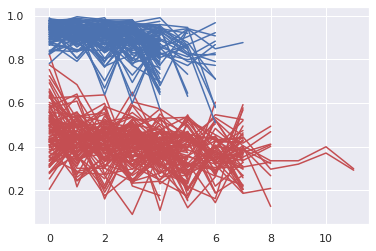

In [210]:
N = 100

k = Quiz_in_test_ver2.sort_values(by='answerCode')
for i, (idx, ls) in enumerate(k.iloc[:N].iterrows()):
    difficulty = ls['difficulty']
    plt.plot(difficulty, 'r')

for i, (idx, ls) in enumerate(k.iloc[-N:].iterrows()):
    difficulty = ls['difficulty']
    plt.plot(difficulty, 'b')

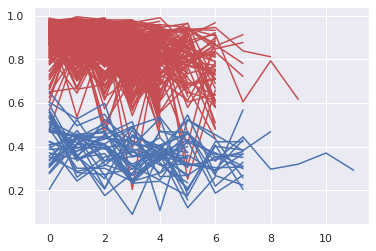

In [132]:
upper, lower = 0.8, 0.4

for i, (idx, ls) in enumerate(Quiz_in_test_ver2.iterrows()):
    answerCode, difficulty = ls['answerCode'], ls['difficulty']

    if upper < answerCode:
        plt.plot(difficulty, 'r')
    if answerCode < lower:
        plt.plot(difficulty, 'b')

## testId의 앞 숫자가 정답률에 영향을 줄까?

> A060000001 -> 060

> 결론 : 꽤 영향이 크다

In [8]:
test_class = df

In [9]:
test_class['class'] = df['testId'].map(lambda x: x[1:4])
test_class

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,class
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,060
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,060
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,060
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,060
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,060
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,030
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,040
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,040
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,040


<AxesSubplot:xlabel='class'>

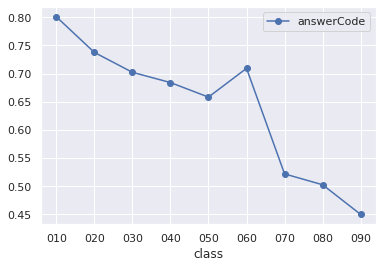

In [234]:
test_class.groupby('class').agg({'answerCode':percentile}).plot(marker='o')

## 학생 중 성장률이 특별히 가파른 아이와 성장률이 지독하게 낮은 아이들의 차이가 극명할까?

> 만약에 있다면 이 성장률을 피쳐로 놓을 만한가?

In [9]:
test_time = df.groupby(['userID', 'testId']).agg({'answerCode': percentile, 'Timestamp':max})
test_time.reset_index(inplace=True)
test_time.set_index('userID', inplace=True)
test_time = test_time.groupby('userID').apply(lambda x: x.sort_values(by='Timestamp'))
test_time

,testId,answerCode,Timestamp
userID,,,
0,A060000001,1.000000,2020-03-24 00:17:47
0,A060000003,0.857143,2020-03-26 05:54:11
0,A060000005,0.857143,2020-03-31 05:05:48
0,A060000007,1.000000,2020-04-02 05:04:08
0,A080000002,0.833333,2020-04-06 00:38:05
...,...,...,...
7440,A050000096,0.400000,2020-08-19 04:58:52
7440,A030000136,0.600000,2020-09-23 09:21:53
7440,A030000197,0.200000,2020-10-21 08:33:20


In [172]:
grade_per_user = test_time.groupby('userID').agg({'answerCode':list})
grade_per_user

,answerCode
userID,
0,"[1.0, 0.8571428571428571, 0.8571428571428571, ..."
1,"[0.8, 0.8, 0.8, 1.0, 1.0, 0.8, 0.8, 0.8, 0.4, ..."
2,"[1.0, 1.0, 0.8, 0.6, 0.8, 0.8, 0.1428571428571..."
5,"[1.0, 0.75, 0.875, 1.0, 1.0, 0.75, 1.0, 0.875,..."
6,"[1.0, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, ..."
...,...
7436,"[1.0, 0.16666666666666666, 0.4]"
7437,"[0.8333333333333334, 0.0, 0.14285714285714285]"
7438,"[0.6666666666666666, 0.8, 0.8]"


In [211]:
import numpy as np

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

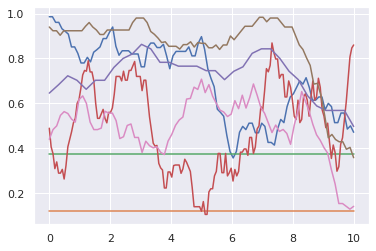

In [226]:
window = 10

for idx, row in grade_per_user.sample(7).iterrows():
    y = row['answerCode']
    y = np.array(y)
    y = moving_average(y, window)
    
    x = np.linspace(0, 10, len(y))
    plt.plot(x, y)

## 에밍하우스의 망각곡선을 고려해서 시험지 사이의 시간간격과 성적 변화가 유의미한지 확인하기

In [10]:
test_time

,testId,answerCode,Timestamp
userID,,,
0,A060000001,1.000000,2020-03-24 00:17:47
0,A060000003,0.857143,2020-03-26 05:54:11
0,A060000005,0.857143,2020-03-31 05:05:48
0,A060000007,1.000000,2020-04-02 05:04:08
0,A080000002,0.833333,2020-04-06 00:38:05
...,...,...,...
7440,A050000096,0.400000,2020-08-19 04:58:52
7440,A030000136,0.600000,2020-09-23 09:21:53
7440,A030000197,0.200000,2020-10-21 08:33:20


In [76]:
idx = 7440
df = test_time.loc[idx]

obj = df[['answerCode', 'Timestamp']]
res = obj - obj.shift(1)
res['Timestamp'] = res['Timestamp'].dt.days
df['growth'] = res['answerCode']
df['elapsed_day'] = res['Timestamp']
df

/tmp/ipykernel_4780/3456001089.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['growth'] = res['answerCode']
/tmp/ipykernel_4780/3456001089.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elapsed_day'] = res['Timestamp']


,testId,answerCode,Timestamp,growth,elapsed_day
userID,,,,,
7440,A050000096,0.4,2020-08-19 04:58:52,NaN,NaN
7440,A030000136,0.6,2020-09-23 09:21:53,0.2,35.0
7440,A030000197,0.2,2020-10-21 08:33:20,-0.4,27.0


In [10]:
def cal(df):
    obj = df[['answerCode', 'Timestamp']]
    res = obj - obj.shift(1)
    res['Timestamp'] = res['Timestamp'].dt.days
    df['growth'] = res['answerCode']
    df['elapsed_day'] = res['Timestamp']
    return df

In [11]:
tmp = test_time.groupby('userID').apply(cal)

<AxesSubplot:xlabel='elapsed_day'>

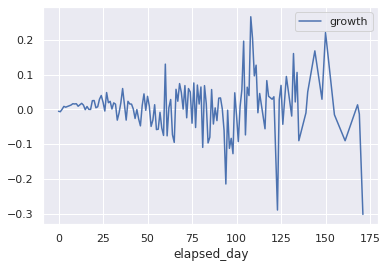

In [32]:
k = tmp.groupby('elapsed_day').agg({'testId':'count', 'growth':'mean'})
k[k['testId'] > 10].plot(y='growth')

## 문제 풀이 시간이 정답률에 문제를 주나??[밤에 풀 때, 낮에 풀 때]

In [33]:
test_time

,testId,answerCode,Timestamp
userID,,,
0,A060000001,1.000000,2020-03-24 00:17:47
0,A060000003,0.857143,2020-03-26 05:54:11
0,A060000005,0.857143,2020-03-31 05:05:48
0,A060000007,1.000000,2020-04-02 05:04:08
0,A080000002,0.833333,2020-04-06 00:38:05
...,...,...,...
7440,A050000096,0.400000,2020-08-19 04:58:52
7440,A030000136,0.600000,2020-09-23 09:21:53
7440,A030000197,0.200000,2020-10-21 08:33:20


In [38]:
test_time['time'] = test_time.Timestamp.dt.hour

<AxesSubplot:xlabel='time'>

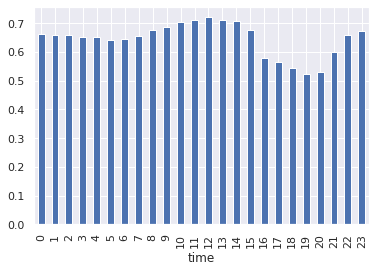

In [51]:
test_time.groupby('time')['answerCode'].mean().plot.bar()

<AxesSubplot:xlabel='time'>

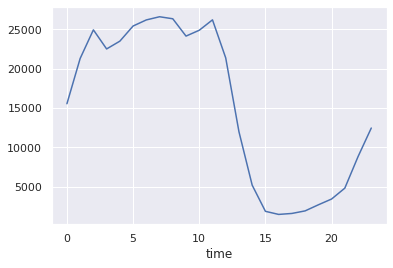

In [50]:
test_time.groupby('time')['answerCode'].count().plot.line()

## 중복해서 푼 문제의 성적 상승률??


In [60]:
df.sort_values(by='assessmentItemID')

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
234540,316,A010001001,A010000001,1,2020-05-07 00:54:25,5844
894162,1316,A010001001,A010000001,1,2020-03-30 01:42:46,5844
1709067,3070,A010001001,A010000001,1,2020-03-24 10:33:43,5844
762550,1106,A010001001,A010000001,1,2020-04-16 03:03:42,5844
375596,513,A010001001,A010000001,1,2020-03-19 04:20:07,5844
...,...,...,...,...,...,...
1319655,2126,A090074006,A090000074,1,2020-12-23 00:07:28,2648
1179305,1832,A090074006,A090000074,1,2020-11-18 05:28:21,2648
116317,150,A090074006,A090000074,0,2020-11-27 03:42:29,2648
520749,729,A090074006,A090000074,1,2020-11-25 08:08:37,2648


In [59]:
df.groupby(['userID', 'testId']).apply(list)

userID  testId    
0       A020000172    [userID, assessmentItemID, testId, answerCode,...
        A020000174    [userID, assessmentItemID, testId, answerCode,...
        A020000181    [userID, assessmentItemID, testId, answerCode,...
        A020000182    [userID, assessmentItemID, testId, answerCode,...
        A020000183    [userID, assessmentItemID, testId, answerCode,...
                                            ...                        
7440    A030000136    [userID, assessmentItemID, testId, answerCode,...
        A030000197    [userID, assessmentItemID, testId, answerCode,...
        A050000096    [userID, assessmentItemID, testId, answerCode,...
7441    A030000071    [userID, assessmentItemID, testId, answerCode,...
        A040000165    [userID, assessmentItemID, testId, answerCode,...
Length: 365164, dtype: object